In [1]:
# ==============================================================
# 0. Imports & global knobs
# ==============================================================
import numpy as np, pandas as pd, torch, time, matplotlib.pyplot as plt
from torch.distributions import Beta
torch.set_default_dtype(torch.double)

N_ASSETS   = 6
R_RATE     = 0.03
N_PATHS_AAD= 60_000          # paths for AAD / pathwise
SEED_BASE  = 42
torch.manual_seed(SEED_BASE)
np.random.seed(SEED_BASE)


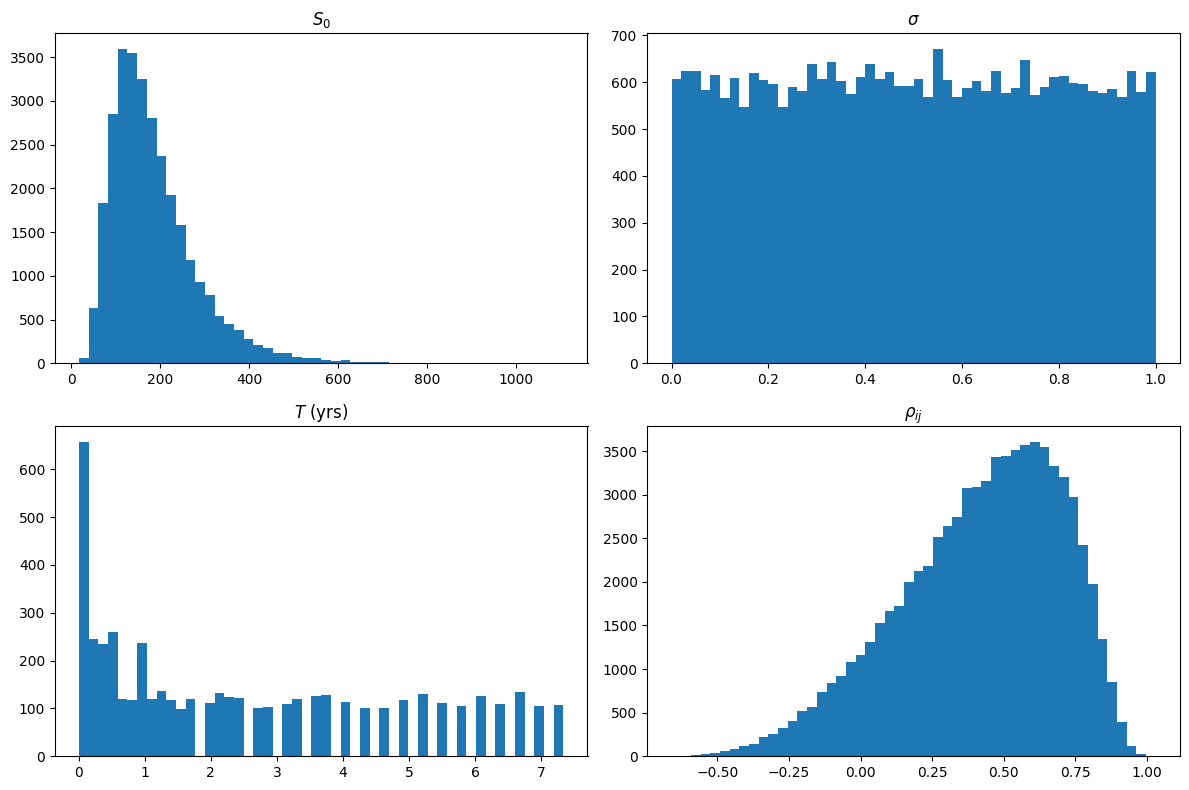

In [2]:

# ==============================================================
# 1. Ferguson-Green sampler  (+ sanity-check plots)
# ==============================================================
def fg_sample(n_assets=N_ASSETS):
    Z      = np.random.normal(0.5, np.sqrt(0.25), n_assets)
    S0     = 100*np.exp(Z)
    sigma  = np.random.uniform(0,1,n_assets)
    X      = np.random.randint(1,44)
    T      = (X**2)/252.0
    beta   = Beta(torch.tensor([5.]), torch.tensor([2.]))
    C      = torch.eye(n_assets, dtype=torch.double)
    for i in range(n_assets):
        for j in range(i+1,n_assets):
            C[i,j] = C[j,i] = 2*beta.sample().item() - 1
    # project to SPD
    ev, evec = torch.linalg.eigh(C)
    C = evec @ torch.diag(torch.clamp(ev, min=1e-4)) @ evec.T
    return dict(S0=S0, sigma=sigma, T=T, rho=C.numpy(), K=100.0)

# --- one-time diagnostic plots (skip when scaling) -------------
if True:
    N_DIAG = 5_000
    S0s,sigs,Ts,rhos=[],[],[],[]
    for _ in range(N_DIAG):
        q = fg_sample()
        S0s.extend(q['S0']); sigs.extend(q['sigma']); Ts.append(q['T'])
        rhos.extend(q['rho'][np.triu_indices(N_ASSETS,1)])
    fig,ax = plt.subplots(2,2,figsize=(12,8))
    ax[0,0].hist(S0s ,50); ax[0,0].set_title('$S_0$')
    ax[0,1].hist(sigs,50); ax[0,1].set_title('$\\sigma$')
    ax[1,0].hist(Ts  ,50); ax[1,0].set_title('$T$ (yrs)')
    ax[1,1].hist(rhos,50); ax[1,1].set_title('$\\rho_{ij}$')
    plt.tight_layout(); plt.show()


In [3]:

# ==============================================================
# 2. Vectorised Monte-Carlo path engine
#    (accepts optional Z for common-random-numbers)
# ==============================================================
def mc_paths(S0, sigma, T, rho, n_paths, n_steps=64, r=R_RATE, Z=None):
    d, dt = S0.numel(), T / n_steps
    chol  = torch.linalg.cholesky(rho)
    if Z is None:
        Z = torch.randn(n_paths, n_steps, d)
    Z = Z @ chol.T
    s = S0.repeat(n_paths, 1)
    drift  = (r - 0.5 * sigma**2) * dt
    vol_dt = sigma * torch.sqrt(dt)
    for t in range(n_steps):
        s = s * torch.exp(drift + vol_dt * Z[:, t, :])
    return s.mean(dim=1)


In [4]:

# ==============================================================
# 3. AAD - first-order Greeks (Δ, ν, ρ, θ) – no Gamma here
# ==============================================================
def greeks_aad(p, n_paths=N_PATHS_AAD):
    S0    = torch.tensor(p['S0'],    requires_grad=True)
    sigma = torch.tensor(p['sigma'], requires_grad=True)
    T     = torch.tensor(p['T'],     requires_grad=True)
    r     = torch.tensor(R_RATE,     requires_grad=True)
    rho_m = torch.tensor(p['rho'])
    K     = p['K']

    basket = mc_paths(S0, sigma, T, rho_m, n_paths, r=r)
    price  = (torch.exp(-r*T) * torch.clamp(basket-K, 0)).mean()

    dS0, dSig, dr, dT = torch.autograd.grad(
        price, (S0, sigma, r, T), create_graph=False
    )

    return dict(price = price.item(),
                delta = dS0.detach().numpy(),
                vega  = dSig.detach().numpy(),
                rho   = dr.item(),
                theta = dT.item())


In [5]:

# ----------------------------------------------------------------
# 3b. Fast diagonal Γ estimator (finite-difference, CRN)
# ----------------------------------------------------------------
def gamma_fd_fast(p, *, n_paths=40_000, n_steps=64, eps=1e-4):
    S0    = torch.tensor(p['S0'])
    sigma = torch.tensor(p['sigma'])
    T     = torch.tensor(p['T'])
    rho_m = torch.tensor(p['rho'])
    K     = p['K']
    r     = R_RATE
    d     = S0.numel()

    n_batch = 1 + 2*d
    S0_mat  = S0.repeat(n_batch, 1)
    for i in range(d):
        h = eps * S0[i]
        S0_mat[1 + 2*i,   i] += h
        S0_mat[1 + 2*i+1, i] -= h

    Z = torch.randn(n_paths, n_steps, d)
    prices = torch.empty(n_batch)

    for j in range(n_batch):
        basket = mc_paths(S0_mat[j], sigma, T, rho_m,
                          n_paths, n_steps, r=r, Z=Z)
        prices[j] = (torch.exp(-r*T) * torch.clamp(basket-K, 0)).mean()

    base  = prices[0].item()
    gamma = torch.empty(d)

    for i in range(d):
        h = eps * S0[i]
        up, dn = prices[1 + 2*i], prices[1 + 2*i + 1]
        gamma[i] = (up - 2*base + dn) / (h*h)

    return gamma.numpy()


In [6]:

# ==============================================================
# 4. Speed & accuracy sanity check (AAD vs FD)
# ==============================================================
p_test = fg_sample()
t0 = time.perf_counter(); g_aad = greeks_aad(p_test); t_aad = time.perf_counter() - t0
t0 = time.perf_counter(); g_gam = gamma_fd_fast(p_test); t_gam = time.perf_counter() - t0

print(f"Price  : {g_aad['price']:.4f}")
print(f"Δ shape: {g_aad['delta'].shape}  | ν shape: {g_aad['vega'].shape}")
print(f"Γ diag : {g_gam}")
print(f"Timing : AAD {t_aad:.2f}s  |  FD-Γ {t_gam:.2f}s")


Price  : 111.6062
Δ shape: (6,)  | ν shape: (6,)
Γ diag : [ 2.97334524e-11  1.97645394e-11  4.74205203e-10  8.52915161e-12
 -7.86148326e-11  5.36994909e-11]
Timing : AAD 0.93s  |  FD-Γ 1.30s


In [7]:

# ==============================================================
# 5. Cohesive dataset generator  (AAD  + FD-Gamma)
# ==============================================================
def generate_dataset(n_rows:int, n_paths:int=50_000, save=None):
    rows = []
    for _ in range(n_rows):
        q = fg_sample()
        g1 = greeks_aad(q, n_paths=n_paths)     # price, Δ, ν, ρ, θ
        g2 = gamma_fd_fast(q, n_paths=n_paths)  # Γ (diagonal)

        rows.append({**{f"S0_{i}":   q['S0'][i]    for i in range(N_ASSETS)},
                     **{f"sigma_{i}":q['sigma'][i] for i in range(N_ASSETS)},
                     "T": q['T'], "price": g1['price'],
                     "rho_greek": g1['rho'], "theta": g1['theta'],
                     **{f"delta_{i}": g1['delta'][i] for i in range(N_ASSETS)},
                     **{f"gamma_{i}": g2[i]          for i in range(N_ASSETS)},
                     **{f"vega_{i}":  g1['vega'][i]  for i in range(N_ASSETS)}})

    df = pd.DataFrame(rows)
    if save:
        df.to_parquet(save) if save.endswith(".parquet") else df.to_csv(save, index=False)
    return df

# Tiny demo (scale rows / paths up later)
df_demo = generate_dataset(100, n_paths=30_000, save="demo.csv")
print("Demo dataset :", df_demo.shape)


Demo dataset : (100, 34)


# Finite Differences Only 

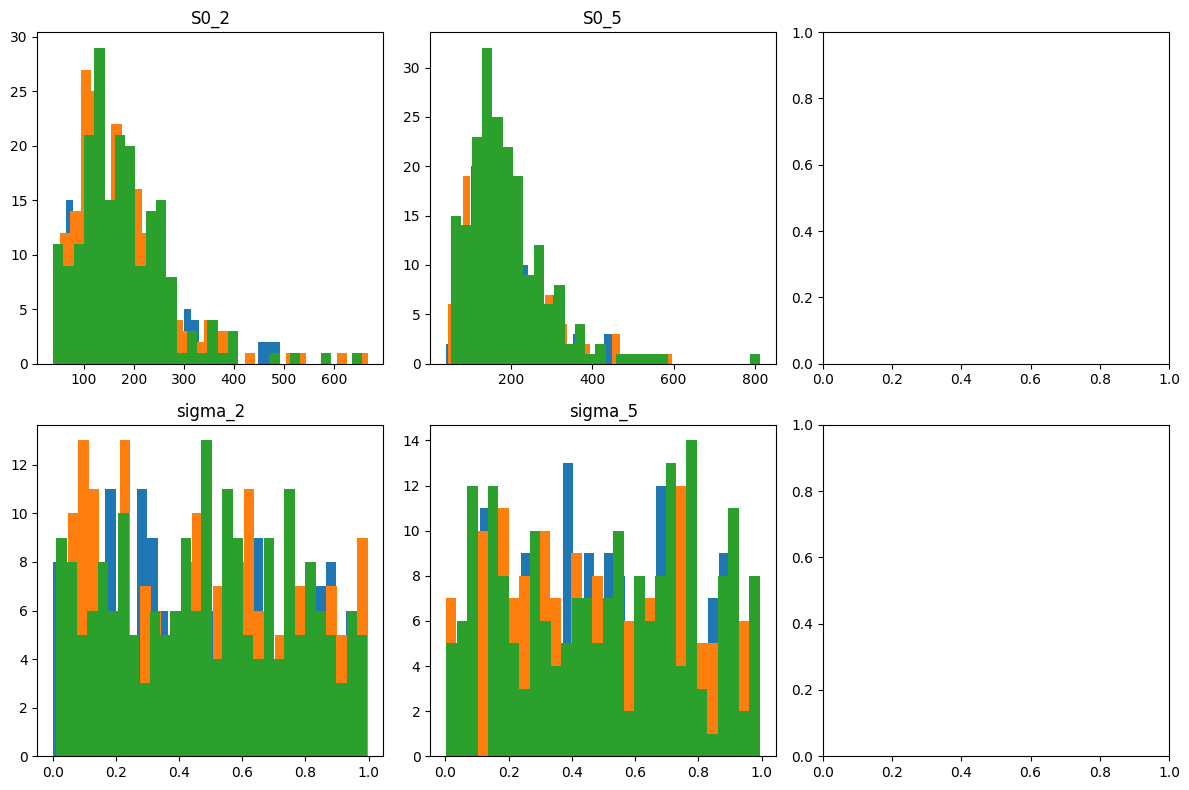

Inconsistency in vega at row 0: [ 0.         -4.62377153 -0.49384896 -0.0317     25.21065504 -5.35971258] [ 0.         -2.84260555 -4.26172682 -5.17725922 29.56518531 -2.59481434]


KeyError: 'theta_0'

In [19]:
# ==============================================================
# 0. Imports & global knobs  (Ferguson–Green replication + diagnostics)
# ==============================================================
import numpy as np, pandas as pd, torch, time, math
import matplotlib.pyplot as plt
from torch.distributions import Beta
from typing import Optional

torch.set_default_dtype(torch.double)

N_ASSETS   = 6            # six underlyings
R_RATE     = 0.0          # forward measure → r = 0
N_PATHS_MC = 10_000       # inner Monte Carlo paths
SEED_BASE  = 42
EPS_REL    = 1e-4         # relative bump for finite differences

torch.manual_seed(SEED_BASE)
np.random.seed(SEED_BASE)

# ==============================================================
# 1. LKJ C-vine correlation generator  (paper Appendix B)
# ==============================================================
def cvine_corr(d: int, a: float = 5.0, b: float = 2.0) -> torch.Tensor:
    beta = Beta(torch.tensor([a]), torch.tensor([b]))
    P    = torch.eye(d, dtype=torch.double)
    for k in range(d - 1):
        for i in range(k + 1, d):
            r = 2 * beta.sample().item() - 1.0
            for m in range(k - 1, -1, -1):
                r = r * math.sqrt((1 - P[m, i]**2)*(1 - P[m, k]**2)) + P[m, i]*P[m, k]
            P[k, i] = P[i, k] = r
    ev, evec = torch.linalg.eigh(P)
    return evec @ torch.diag(torch.clamp(ev, min=1e-6)) @ evec.T

# ==============================================================
# 2. Ferguson–Green outer-MC sampler
# ==============================================================
def fg_sample():
    Z     = np.random.normal(0.5, math.sqrt(0.25), N_ASSETS)
    S0    = 100 * np.exp(Z)
    sigma = np.random.uniform(0.0, 1.0, N_ASSETS)
    X     = np.random.randint(1, 44)
    T     = (X**2)/252.0
    C     = cvine_corr(N_ASSETS).numpy()
    return dict(S0=S0, sigma=sigma, T=T, rho=C, K=100.0)

# ==============================================================
# 3. Vectorised GBM path engine (inner MC)
# ==============================================================
def mc_paths(S0, sigma, T, rho, *, n_paths=N_PATHS_MC, n_steps=64, Z: Optional[torch.Tensor]=None):
    S0, sigma, rho = map(lambda x: torch.as_tensor(x, dtype=torch.double), (S0, sigma, rho))
    dt   = float(T)/n_steps
    chol = torch.linalg.cholesky(rho)
    if Z is None:
        Z = torch.randn(n_paths, n_steps, N_ASSETS, dtype=torch.double)
    Z = Z @ chol.T
    s      = S0.repeat(n_paths, 1)
    drift  = -0.5*sigma**2 * dt  # r=0
    vol_dt = sigma*math.sqrt(dt)
    for t in range(n_steps):
        s = s * torch.exp(drift + vol_dt*Z[:, t, :])
    return s

# ==============================================================
# 4. Worst-of basket-call price
# ==============================================================
def price_mc(S0, sigma, T, rho, K, *, n_paths=N_PATHS_MC, n_steps=64, Z=None):
    paths  = mc_paths(S0, sigma, T, rho, n_paths=n_paths, n_steps=n_steps, Z=Z)
    payoff = torch.clamp(paths.min(dim=1).values - K, 0.0)
    return payoff.mean().item()

# ==============================================================
# 5. Finite-difference Greeks (Δ, ν, θ, Γ; ρ=0)
# ==============================================================
def greeks_fd_full(p: dict, *, n_paths=N_PATHS_MC, n_steps=64, eps_rel=EPS_REL):
    S0, sigma = torch.tensor(p['S0']), torch.tensor(p['sigma'])
    T, rho_m  = torch.tensor(p['T']), torch.tensor(p['rho'])
    K         = p['K']
    d         = S0.numel()
    Z0        = torch.randn(n_paths, n_steps, d, dtype=torch.double)
    base      = price_mc(S0, sigma, T, rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)
    delta = torch.empty(d); vega = torch.empty(d); gamma = torch.empty(d)
    eye   = torch.eye(d)
    for i in range(d):
        hS       = eps_rel*S0[i]
        up       = price_mc(S0+hS*eye[i], sigma, T, rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)
        dn       = price_mc(S0-hS*eye[i], sigma, T, rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)
        delta[i] = (up - dn)/(2*hS)
        gamma[i] = (up - 2*base + dn)/(hS*hS)
        hV       = eps_rel*sigma[i]
        up       = price_mc(S0, sigma+hV*eye[i], T, rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)
        dn       = price_mc(S0, sigma-hV*eye[i], T, rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)
        vega[i]  = (up - dn)/(2*hV)
    hT    = eps_rel*T
    up    = price_mc(S0, sigma, T+hT, rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)
    dn    = price_mc(S0, sigma, torch.clamp(T-hT, min=1e-6), rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)
    theta = (up - dn)/(2*hT)
    return dict(price=base, delta=delta.numpy(), vega=vega.numpy(), gamma=gamma.numpy(), rho=0.0, theta=theta.item())

# ==============================================================
# Diagnostics: plotting & consistency checks
# ==============================================================
def plot_parameter_distributions(df: pd.DataFrame):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(N_ASSETS):
        axes[0, i//3].hist(df[f'S0_{i}'], bins=30)
        axes[0, i//3].set_title(f'S0_{i}')
        axes[1, i//3].hist(df[f'sigma_{i}'], bins=30)
        axes[1, i//3].set_title(f'sigma_{i}')
    plt.tight_layout()
    plt.show()

def greek_consistency_check(sample_df: pd.DataFrame, n_paths: int):
    for idx, row in sample_df.iterrows():
        p = { 'S0': sample_df.loc[idx, [f'S0_{i}' for i in range(N_ASSETS)]].values,
              'sigma': sample_df.loc[idx, [f'sigma_{i}' for i in range(N_ASSETS)]].values,
              'T': sample_df.loc[idx, 'T'], 'rho': None, 'K': 100.0 }
        p['rho'] = cvine_corr(N_ASSETS).numpy()  # fresh corr
        g_new = greeks_fd_full(p, n_paths=n_paths)
        for greek in ['delta', 'vega', 'gamma', 'theta']:
            original = np.array([ sample_df.loc[idx, f'{greek}_{i}'] for i in range(N_ASSETS)])
            if not np.allclose(original, g_new[greek], rtol=1e-2, atol=1e-2):
                print(f'Inconsistency in {greek} at row {idx}:', original, g_new[greek])

# ==============================================================
# 6. Dataset generator + diagnostics
# ==============================================================
def generate_dataset(n_rows: int, *, n_paths: int = N_PATHS_MC, save: Optional[str]=None, diagnostics=False):
    rows = []
    for _ in range(n_rows):
        q = fg_sample()
        g = greeks_fd_full(q, n_paths=n_paths)
        row = { **{f'S0_{i}': q['S0'][i] for i in range(N_ASSETS)},
                **{f'sigma_{i}': q['sigma'][i] for i in range(N_ASSETS)},
                'T': q['T'], 'price': g['price'] }
        for i in range(N_ASSETS):
            row[f'delta_{i}'] = g['delta'][i]
            row[f'vega_{i}']  = g['vega'][i]
            row[f'gamma_{i}'] = g['gamma'][i]
        row['rho_greek'] = g['rho']; row['theta'] = g['theta']
        rows.append(row)
    df = pd.DataFrame(rows)
    if save: df.to_parquet(save) if save.endswith('.parquet') else df.to_csv(save, index=False)
    if diagnostics:
        plot_parameter_distributions(df)
        greek_consistency_check(df, n_paths)
    return df

# --------------------------------------------------------------
# 7. Sanity demo
# --------------------------------------------------------------
if __name__=='__main__':
    df = generate_dataset(200, diagnostics=True)
    print(df.head())

## Without Checks

In [17]:
# ==============================================================
# 0. Imports & global knobs (aligns with Ferguson–Green paper)
# ==============================================================

import numpy as np, pandas as pd, torch, time, math
from torch.distributions import Beta
from typing import Optional

torch.set_default_dtype(torch.double)

N_ASSETS   = 6            # six underlyings (paper)
R_RATE     = 0.0          # they price in forward space → r = 0
N_PATHS_MC = 10_000       # inner Monte‑Carlo paths
SEED_BASE  = 42

torch.manual_seed(SEED_BASE)
np.random.seed(SEED_BASE)

EPS_REL    = 1e-4         # relative bump for finite‑difference Greeks

# ==============================================================
# 1. C‑vine LKJ correlation generator (paper Appendix B)
# ==============================================================

def cvine_corr(d: int, a: float = 5.0, b: float = 2.0) -> torch.Tensor:
    """Lewandowski–Kurowicka–Joe C‑vine; identical to F&G."""
    beta = Beta(torch.tensor([a]), torch.tensor([b]))
    P    = torch.eye(d, dtype=torch.double)
    for k in range(d - 1):
        for i in range(k + 1, d):
            r = 2 * beta.sample().item() - 1.0
            for m in range(k - 1, -1, -1):  # vine recursion
                r = r * math.sqrt((1 - P[m, i] ** 2) * (1 - P[m, k] ** 2)) + P[m, i] * P[m, k]
            P[k, i] = P[i, k] = r
    # SPD clean‑up
    ev, evec = torch.linalg.eigh(P)
    return evec @ torch.diag(torch.clamp(ev, min=1e-6)) @ evec.T

# ==============================================================
# 2. Ferguson–Green parameter sampler (outer MC)
# ==============================================================

def fg_sample():
    Z     = np.random.normal(0.5, math.sqrt(0.25), N_ASSETS)
    S0    = 100 * np.exp(Z)
    sigma = np.random.uniform(0.0, 1.0, N_ASSETS)
    X     = np.random.randint(1, 44)           # 1 … 43
    T     = (X ** 2) / 252.0                   # in years
    C     = cvine_corr(N_ASSETS).numpy()
    return dict(S0=S0, sigma=sigma, T=T, rho=C, K=100.0)

# ==============================================================
# 3. Vectorised GBM path engine (inner MC)
# ==============================================================

def mc_paths(S0, sigma, T, rho, *,
             n_paths: int = N_PATHS_MC,
             n_steps: int = 64,
             r: float = R_RATE,
             Z: Optional[torch.Tensor] = None):
    if not isinstance(S0, torch.Tensor):
        S0 = torch.tensor(S0, dtype=torch.double)
    if not isinstance(sigma, torch.Tensor):
        sigma = torch.tensor(sigma, dtype=torch.double)
    if not isinstance(rho, torch.Tensor):
        rho = torch.tensor(rho, dtype=torch.double)

    dt   = float(T) / n_steps
    chol = torch.linalg.cholesky(rho)

    if Z is None:
        Z = torch.randn(n_paths, n_steps, N_ASSETS, dtype=torch.double)
    Z = Z @ chol.T

    s      = S0.repeat(n_paths, 1)
    drift  = -0.5 * sigma ** 2 * dt             # r = 0, forward prices
    vol_dt = sigma * math.sqrt(dt)

    for t in range(n_steps):
        s = s * torch.exp(drift + vol_dt * Z[:, t, :])
    return s  # (n_paths, N_ASSETS)

# ==============================================================
# 4. Worst‑of basket‑call price   V = e^{-rT} max(min(S(T)) − K , 0)
# ==============================================================

def price_mc(S0, sigma, T, rho, K, *,
             n_paths: int = N_PATHS_MC,
             n_steps: int = 64,
             r: float = R_RATE,
             Z: Optional[torch.Tensor] = None):
    paths  = mc_paths(S0, sigma, T, rho, n_paths=n_paths, n_steps=n_steps, r=r, Z=Z)
    worst  = paths.min(dim=1).values
    payoff = torch.clamp(worst - K, 0.0)
    return payoff.mean().item()                 # r = 0 so no discount factor

# ==============================================================
# 5. Finite‑difference Greeks  (Δ, ν, ρ, θ, Γ)  — all FD
# ==============================================================

def greeks_fd_full(p: dict, *, n_paths: int = N_PATHS_MC, n_steps: int = 64, eps_rel: float = EPS_REL):
    S0    = torch.tensor(p['S0'], dtype=torch.double)
    sigma = torch.tensor(p['sigma'], dtype=torch.double)
    T     = torch.tensor(p['T'], dtype=torch.double)
    rho_m = torch.tensor(p['rho'], dtype=torch.double)
    K     = p['K']
    d     = S0.numel()

    Z0 = torch.randn(n_paths, n_steps, d, dtype=torch.double)  # CRN

    base = price_mc(S0, sigma, T, rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)

    delta = torch.empty(d)
    vega  = torch.empty(d)
    gamma = torch.empty(d)
    eye   = torch.eye(d)

    for i in range(d):
        # spot bump
        hS = eps_rel * S0[i]
        up = price_mc(S0 + hS * eye[i], sigma, T, rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)
        dn = price_mc(S0 - hS * eye[i], sigma, T, rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)
        delta[i] = (up - dn) / (2 * hS)
        gamma[i] = (up - 2 * base + dn) / (hS * hS)

        # vol bump
        hV = eps_rel * sigma[i]
        up = price_mc(S0, sigma + hV * eye[i], T, rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)
        dn = price_mc(S0, sigma - hV * eye[i], T, rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)
        vega[i] = (up - dn) / (2 * hV)

    # rho (risk‑free) — r is zero, bumping around 0 is meaningless; set to 0.
    rho_greek = 0.0

    # theta — central FD on maturity
    hT = eps_rel * T
    up = price_mc(S0, sigma, T + hT, rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)
    dn = price_mc(S0, sigma, torch.clamp(T - hT, min=1e-6), rho_m, K, n_paths=n_paths, n_steps=n_steps, Z=Z0)
    theta = (up - dn) / (2 * hT)

    return dict(price=base,
                delta=delta.numpy(),
                vega=vega.numpy(),
                gamma=gamma.numpy(),
                rho=rho_greek,
                theta=theta.item())

# ==============================================================
# 6. Dataset generator (FD Greeks, worst‑of payoff)
# ==============================================================

def generate_dataset(n_rows: int, *, n_paths: int = N_PATHS_MC, save: Optional[str] = None):
    rows = []
    for _ in range(n_rows):
        q = fg_sample()
        g = greeks_fd_full(q, n_paths=n_paths)

        row = {
            **{f"S0_{i}":    q['S0'][i]    for i in range(N_ASSETS)},
            **{f"sigma_{i}": q['sigma'][i] for i in range(N_ASSETS)},
            "T":     q['T'],
            "price": g['price']
        }
        for i in range(N_ASSETS):
            row[f"delta_{i}"] = g['delta'][i]
            row[f"vega_{i}"]  = g['vega'][i]
            row[f"gamma_{i}"] = g['gamma'][i]
        row["rho_greek"] = g['rho']
        row["theta"]     = g['theta']
        rows.append(row)

    df = pd.DataFrame(rows)
    if save:
        if save.endswith(".parquet"):
            df.to_parquet(save)
        else:
            df.to_csv(save, index=False)
    return df

# --------------------------------------------------------------
# 7. Sanity demo (100 rows × 10 k paths)
# --------------------------------------------------------------
if __name__ == "__main__":
    t0 = time.perf_counter()
    df_demo = generate_dataset(1, n_paths=10_000, save="demo_fg.csv")
    print("Demo shape:", df_demo.shape, "| elapsed", time.perf_counter() - t0, "s")


Demo shape: (1, 34) | elapsed 1.0695956999552436 s
